# Wind Turbine Farm Management Assistant

### Load the required libraries

In [7]:
import time
from datetime import datetime
import os
import io

from PIL import Image
from dotenv import load_dotenv
from openai import AzureOpenAI
from openai.types.beta.threads.message_content_text import MessageContentText
from openai.types.beta.threads.message_content_image_file import MessageContentImageFile

### Load the environment variables

In [8]:
load_dotenv()
api_endpoint = os.getenv("OPENAI_URI")
api_key = os.getenv("OPENAI_KEY")
api_version = os.getenv("OPENAI_VERSION")
api_deployment_name = os.getenv("OPENAI_GPT_DEPLOYMENT")
email_URI = os.getenv("EMAIL_URI")

### Create an AzureOpenAI client

In [9]:
client = AzureOpenAI(api_key=api_key,
        api_version=api_version,
        azure_endpoint=api_endpoint)

### Define the Assistant tools

In [10]:
tools_list = [
    {"type": "code_interpreter"},
]

### Upload the Assistant file(s)

In [11]:
DATA_FOLDER = "../data/energy/"
def upload_file(client, path):
    file = client.files.create(file=open(path, "rb"), purpose="assistants")
    return file

arr = os.listdir(DATA_FOLDER)
assistant_files = []
for file in arr:
    filePath =  DATA_FOLDER + file
    assistant_files.append(upload_file(client, filePath))

file_ids = [file.id for file in assistant_files]

### Create an Assistant and a Thread

In [12]:
assistant = client.beta.assistants.create(
    name="Portfolio Management Assistant",
    instructions="You are an assistant that can help manage wind turbine farm. " +
    "The turbines operating ranges are output voltages of 33kv-35kv and RPM of 15-25. Wind speed is measured in miles per hour." +
    "Maintenance should occur every 12 months. Greet the user by saying, 'Welcome Turbine Management Assistant.'",
    tools=tools_list, 
    model=api_deployment_name,
    file_ids=file_ids
)

thread = client.beta.threads.create()

### Format and display the Assistant Messages for text and image

In [13]:
def format_messages(messages):
    message_list = []

    # Get all the messages till the last user message
    for message in messages:
        message_list.append(message)
        if message.role == "user":
            break

    # Reverse the messages to show the last user message first
    message_list.reverse()

    # Print the user or Assistant messages or images
    for message in message_list:                
        for item in message.content:
            # Determine the content type
            if isinstance(item, MessageContentText):
                print(f'{message.role}:\n{item.text.value}\n')
            elif isinstance(item, MessageContentImageFile):
                # Retrieve image from file id
                response_content = client.files.content(item.image_file.file_id)
                data_in_bytes = response_content.read()
                # Convert bytes to image
                readable_buffer = io.BytesIO(data_in_bytes)
                image = Image.open(readable_buffer)
                # Resize image to fit in terminal
                width, height = image.size
                image = image.resize((width //2, height //2), Image.LANCZOS)
                # Display image
                image.show()

### Process the user messages

In [14]:
def process_message(content:str):
    client.beta.threads.messages.create(
        thread_id=thread.id,
        role="user",        
        content=content
    )

    run = client.beta.threads.runs.create(
        thread_id=thread.id,
        assistant_id=assistant.id,
        instructions="The current date and time is: " + datetime.now().strftime("%x %X") + ". "
    )

    print("processing...")
    while True:
        run = client.beta.threads.runs.retrieve(thread_id=thread.id, run_id=run.id)
        if run.status == "completed":
            messages = client.beta.threads.messages.list(thread_id=thread.id)            
            format_messages(messages)
            break
        elif run.status == "failed":
            messages = client.beta.threads.messages.list(thread_id=thread.id)            
            format_messages(messages)
            break
        elif run.status == "expired":
            # Handle expired
            break
        elif run.status == "cancelled":
            # Handle cancelled
            break
        elif run.status == "requires_action":
            pass
        else:
            #print("in progress...",run.status)
            time.sleep(5)

###  Have a conversation with the Assistant

In [15]:
process_message("What is the status of turbine 1001 and 1003?")

processing...
user:
What is the status of turbine 1001 and 1003?

assistant:
To provide information on the status of turbines 1001 and 1003, I need to review the details from the uploaded file. First, I will check the file's contents to understand its format and then extract the relevant information about turbines 1001 and 1003.

Let's start by examining the file contents.

assistant:
It appears that the file can be read as plain text. Let's take a look at the first few lines to understand the data structure and locate the information regarding the status of turbines 1001 and 1003. I will proceed with displaying the contents of the initial lines.

assistant:
The file appears to be in CSV format with the following columns: `Turbine_ID`, `Wind_Speed`, `RPM`, `Voltage`, and `Maintenance_Date`. From the initial lines we can observe the entries for Turbines `1001` and `1003`:

- Turbine `1001` has the following attributes: `Wind_Speed` = 32, `RPM` = 18, `Voltage` = 33, `Maintenance_Date` = 

processing...
user:
Generate a chart of the normal operating ranges?

assistant:
To generate a chart representing the normal operating ranges for turbines, we would need to know what constitutes "normal" for each parameter (Wind_Speed, RPM, Voltage). The normal operating ranges are typically industry-specific standards or defined by the manufacturer's guidelines for safe and efficient operation.

Since I do not have that specific information, I will assume arbitrary normal operating ranges for each parameter to demonstrate how such a chart could be created. Please provide the actual normal operating ranges if you wish to see a chart based on the real data.

Let's choose the following arbitrary normal operating ranges for demonstration purposes:
- Wind_Speed: 25 - 40 (units assumed to be m/s)
- RPM: 10 - 25 (rotations per minute)
- Voltage: 30 - 40 (units assumed to be kV)

We will use a bar chart to visualize these ranges, where each turbine parameter has a range that is considered "no

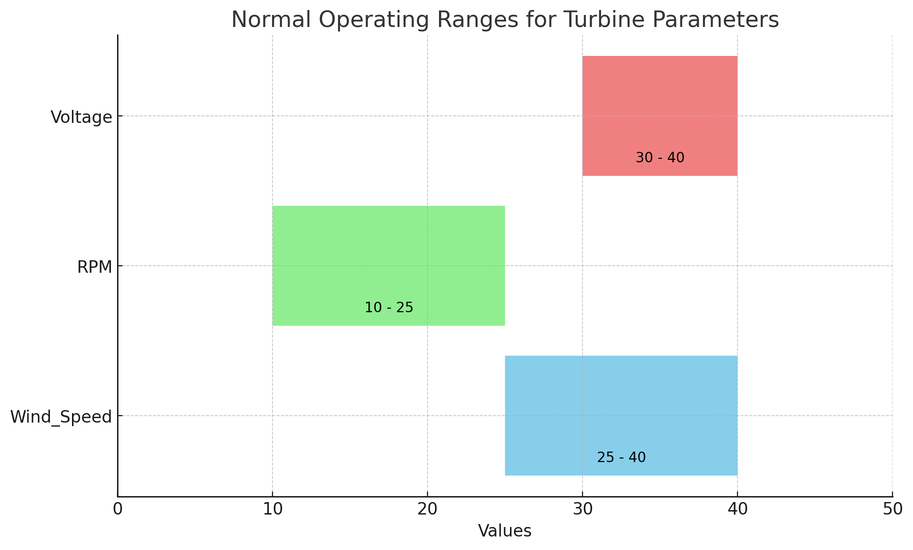

assistant:
Here is the chart displaying the normal operating ranges for turbine parameters, based on the arbitrary ranges provided earlier. Each bar represents the range of values considered "normal" for that parameter, which are as follows:

- Wind Speed: Normal range from 25 to 40 m/s
- RPM: Normal range from 10 to 25 rotations per minute
- Voltage: Normal range from 30 to 40 kV

For actual charts based on real data, please provide the specific normal operating ranges for each parameter.



In [16]:
process_message("Generate a chart of the normal operating ranges?")

In [17]:
process_message('What turbines are operating outside normal ranges?\n\n'+
                'Sample: [{"turbine":"","voltage":30,"RPM":15,"reason":"Voltage outside of normal range."},\n' +
                '{"turbine":"","voltage":30,"rpm":10,"reason":"RPM and Voltage outside of normal ranges."},\n' +
                '{"turbine":"","voltage":33,"rpm":5,"reason":"RPM outside of normal range."}]\n\n' +
                'Output format: [{"turbine":"","voltage":0,"RPM":0,"reason":""}]\n\n'
                +'Output in JSON format only.')

processing...
user:
What turbines are operating outside normal ranges?

Sample: [{"turbine":"","voltage":30,"RPM":15,"reason":"Voltage outside of normal range."},
{"turbine":"","voltage":30,"rpm":10,"reason":"RPM and Voltage outside of normal ranges."},
{"turbine":"","voltage":33,"rpm":5,"reason":"RPM outside of normal range."}]

Output format: [{"turbine":"","voltage":0,"RPM":0,"reason":""}]

Output in JSON format only.

assistant:
To identify which turbines are operating outside the normal ranges, we first need to define the normal operating ranges for the `voltage` and `RPM`. Let's use the arbitrary ranges defined earlier:

- Voltage: Normal range from 30 to 40 kV
- RPM: Normal range from 10 to 25 rotations per minute

Next, I will examine the turbine data in our DataFrame and compare the `Voltage` and `RPM` columns against these normal ranges to find which turbines are outside of these bounds. Once identified, I will format the results into the requested JSON structure.

assistant:

In [18]:
process_message("What turbines need maintenance?")

processing...
user:
What turbines need maintenance?

assistant:
To identify which turbines need maintenance, we should compare their `Maintenance_Date` with the current date. If the maintenance date is in the past relative to the current date, it means the turbine is due for or overdue for maintenance.

Let's proceed by checking which turbines have a `Maintenance_Date` that precedes the current date. We will use the current date from the system to make this comparison. I will now identify those turbines and provide you with the information.

assistant:
The following turbines require maintenance based on their `Maintenance_Date` being in the past relative to the current date:

- Turbine 1000
- Turbine 1001
- Turbine 1002
- Turbine 1003
- Turbine 1004
- Turbine 1005
- Turbine 1006
- Turbine 1007
- Turbine 1008
- Turbine 1009
- Turbine 1010
- Turbine 1011
- Turbine 1012
- Turbine 1013
- Turbine 1014
- Turbine 1015
- Turbine 1016
- Turbine 1017
- Turbine 1018
- Turbine 1019
- Turbine 1020


### Cleanup

In [19]:
client.beta.assistants.delete(assistant.id)
client.beta.threads.delete(thread.id)
for file in assistant_files:
    client.files.delete(file.id)